In [1]:
import jax
import importlib
from jcm import model as mod
importlib.reload(mod)

def test_speedy_model(time_step=120,
                      save_interval=1,
                      total_time=1,
                      layers=7):
    from dinosaur import primitive_equations_states

    model = mod.SpeedyModel(
        time_step=time_step,
        save_interval=save_interval,
        total_time=total_time,
        layers=layers,
    )

    state = model.get_initial_state()
    state.tracers = {'specific_humidity': primitive_equations_states.gaussian_scalar(model.coords, model.physics_specs)}

    final_state, predictions = model.unroll(state)

    return final_state, predictions, model

In [2]:
jax.config.update('jax_disable_jit', True)
jax.config.update("jax_debug_infs", False)
jax.config.update("jax_debug_nans", False)
final_state, predictions, model = test_speedy_model()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


iptop: ['min: 1.00000, max: 1.00000']
cloudc: ['min: 0.63246, max: 0.63246']
icltop: ['min: 1.00000, max: 1.00000']
iptop: ['min: 1.00000, max: 1.00000']
cloudc: ['min: 0.63246, max: 0.63246']
icltop: ['min: 1.00000, max: 1.00000']
iptop: ['min: 1.00000, max: 1.00000']
cloudc: ['min: 0.63246, max: 0.63246']
icltop: ['min: 1.00000, max: 1.00000']
iptop: ['min: 1.00000, max: 1.00000']
cloudc: ['min: 0.63246, max: 0.63246']
icltop: ['min: 1.00000, max: 1.00000']
iptop: ['min: 1.00000, max: 1.00000']
cloudc: ['min: 0.63246, max: 0.63246']
icltop: ['min: 1.00000, max: 1.00000']
iptop: ['min: 1.00000, max: 1.00000']
cloudc: ['min: 0.63246, max: 0.63246']
icltop: ['min: 1.00000, max: 1.00000']
iptop: ['min: 1.00000, max: 1.00000']
cloudc: ['min: 0.63246, max: 0.63246']
icltop: ['min: 1.00000, max: 1.00000']
iptop: ['min: 1.00000, max: 1.00000']
cloudc: ['min: 0.63246, max: 0.63246']
icltop: ['min: 1.00000, max: 1.00000']
iptop: ['min: 1.00000, max: 1.00000']
cloudc: ['min: 0.63246, max: 0.632

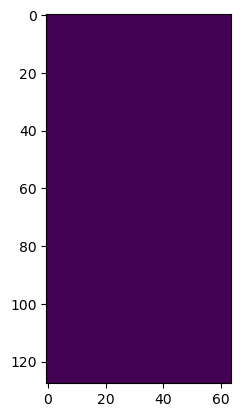

In [2]:
# read icltop.npy into numpy array
import numpy as np
import matplotlib.pyplot as plt
icltop = np.load('icltop.npy')
plt.imshow(icltop)
plt.show()

In [ ]:
jax.config.update('jax_disable_jit', False)
jax.config.update("jax_debug_infs", False)
jax.config.update("jax_debug_nans", False)
final_state, predictions, model = test_speedy_model()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
from dinosaur import primitive_equations as pe

coords = model.coords

diagnostic_final_state = pe.compute_diagnostic_state(final_state, coords)
vertical_velocity = pe.compute_vertical_velocity(final_state, coords)

print('Computed nodal quantities:\n' + '\n'.join(diagnostic_final_state.__dataclass_fields__.keys()))

Computed nodal quantities:
vorticity
divergence
temperature_variation
cos_lat_u
sigma_dot_explicit
sigma_dot_full
cos_lat_grad_log_sp
u_dot_grad_log_sp
tracers


In [4]:
from dinosaur import spherical_harmonic as sh

log_surface_pressure_nodal = coords.horizontal.to_nodal(final_state.log_surface_pressure)
u_nodal, v_nodal = sh.vor_div_to_uv_nodal(coords.horizontal, final_state.vorticity, final_state.divergence)
w_nodal = pe.compute_vertical_velocity(final_state, coords)

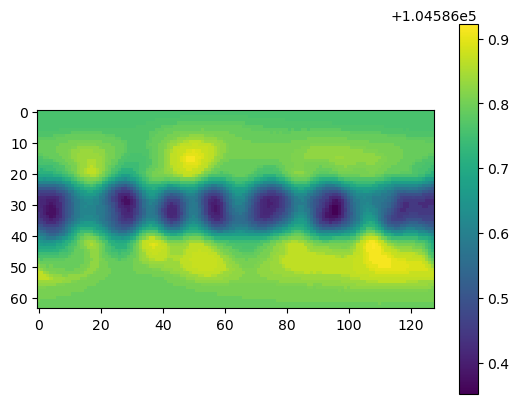

In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.exp(np.squeeze(log_surface_pressure_nodal).T)*1e5)
plt.colorbar()

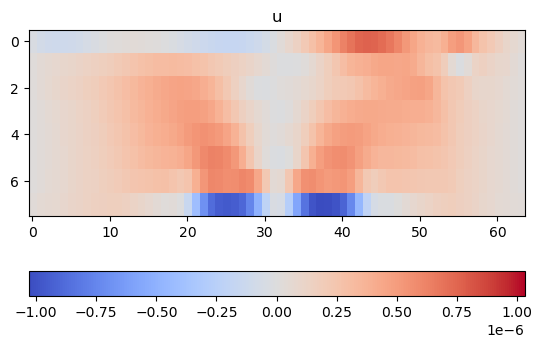

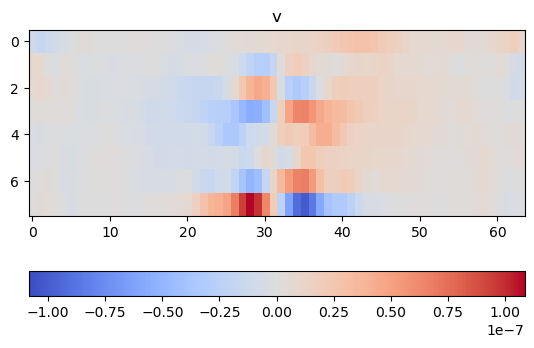

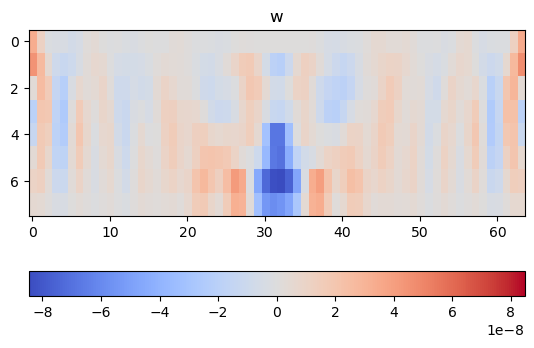

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def plot_variable(variable, title):
    data = np.mean(variable, axis=1)
    vmin = min(np.min(data), -np.max(data))
    vmax = max(np.max(data), -np.min(data))
    plt.imshow(np.mean(variable, axis=1), cmap='coolwarm', vmin=vmin, vmax=vmax, aspect=3)
    plt.title(title)
    plt.colorbar(orientation='horizontal')
    plt.show()

plot_variable(u_nodal, 'u')

# norm = TwoSlopeNorm(vcenter=0)

# plt.imshow(np.mean(u_nodal, axis=1), cmap='coolwarm', norm=norm, aspect=3)
# plt.title('u')
# plt.colorbar(orientation='horizontal')
# plt.show()

plot_variable(v_nodal, 'v')

# plt.imshow(np.mean(v_nodal, axis=1), cmap='coolwarm', aspect=3)
# plt.title('v')
# plt.colorbar(orientation='horizontal')
# plt.show()

plot_variable(w_nodal, 'w')

# plt.imshow(np.mean(w_nodal, axis=1), cmap='coolwarm', aspect=3)
# plt.title('w')
# plt.colorbar(orientation='horizontal')
# plt.show()

temperature_nodal = 288 + diagnostic_final_state.temperature_variation
# plt.imshow(np.mean(temperature_nodal, axis=1), cmap='viridis', aspect=3)
# plt.title('T')
# plt.colorbar(orientation='horizontal')
# plt.show()

# plt.imshow(np.mean(diagnostic_final_state.tracers['specific_humidity'], axis=1), cmap='viridis', aspect=3)
# plt.title('q')
# plt.colorbar(orientation='horizontal')
# plt.show()

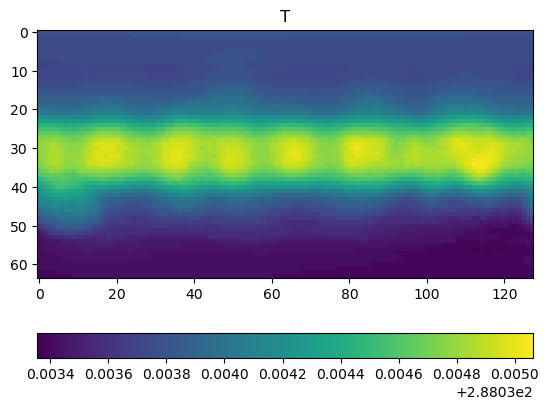

In [7]:
plt.imshow(np.mean(temperature_nodal, axis=0).T, cmap='viridis', aspect='equal')
plt.title('T')
plt.colorbar(orientation='horizontal')
plt.show()

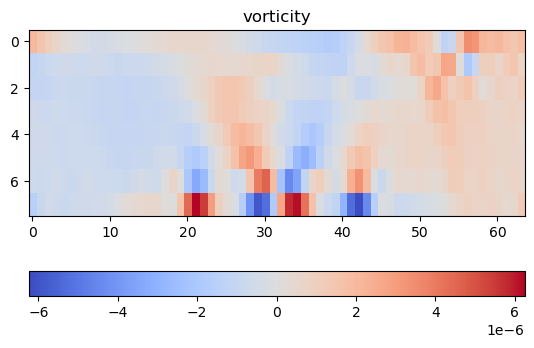

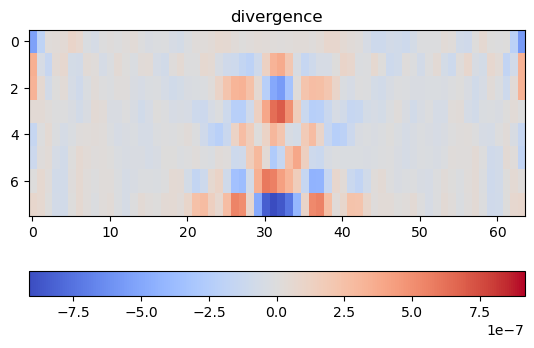

In [8]:
# plt.imshow(np.mean(diagnostic_final_state.vorticity, axis=1), cmap='coolwarm', norm=norm, aspect=3)
# plt.title('vorticity')
# plt.colorbar(orientation='horizontal')
# plt.show()

plot_variable(diagnostic_final_state.vorticity, 'vorticity')

# plt.imshow(np.mean(diagnostic_final_state.divergence, axis=1), cmap='coolwarm', norm=norm, aspect=3)
# plt.title('divergence')
# plt.colorbar(orientation='horizontal')
# plt.show()

plot_variable(diagnostic_final_state.divergence, 'divergence')